In [1]:
#Importing the required modules and general setup
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.stats import iqr
from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleAdiabatic
from galpy.df import quasiisothermaldf
from galpy.util.bovy_coords import *
import sys
sys.path.append('..')

#Importing qdf load data
samples_qdf = np.load('../mock_data/qdf/data/qdf sample cartesian physical.npy')

#Setting up action angle and qdf instances
aA = actionAngleAdiabatic(pot=MWPotential2014,c=True)
qdf = quasiisothermaldf(1./3.,0.2,0.1,1.,1.,pot=MWPotential2014,aA=aA,cutcounter=True)

#convert cylindrical to rectangular
R, phi, z = rect_to_cyl(samples_qdf[:,0], samples_qdf[:,1], samples_qdf[:,2])
vR, vT, vz = rect_to_cyl_vec(samples_qdf[:,3], samples_qdf[:,4], samples_qdf[:,5], samples_qdf[:,0], samples_qdf[:,1], samples_qdf[:,2])
samples_qdf = np.stack((R, phi, z, vR, vT, vz), axis=1)


print('#stars', len(samples_qdf))
print('min/max/mean (R)', min(samples_qdf[:,0]), max(samples_qdf[:,0]), np.mean(samples_qdf[:,0]))
print('min/max/mean (phi)', min(samples_qdf[:,1]), max(samples_qdf[:,1]), np.mean(samples_qdf[:,1]))
print('min/max/mean (z)', min(samples_qdf[:,2]), max(samples_qdf[:,2]), np.mean(samples_qdf[:,2]))
print('min/max/mean (vR)', min(samples_qdf[:,3]), max(samples_qdf[:,3]), np.mean(samples_qdf[:,3]))
print('min/max/mean (vT)', min(samples_qdf[:,4]), max(samples_qdf[:,4]), np.mean(samples_qdf[:,4]))
print('min/max/mean (vz)', min(samples_qdf[:,5]), max(samples_qdf[:,5]), np.mean(samples_qdf[:,5]))
print(np.std(samples_qdf[:,0]), np.std(samples_qdf[:,1]), np.std(samples_qdf[:,2]), np.std(samples_qdf[:,3]), np.std(samples_qdf[:,4]), np.std(samples_qdf[:,5]))

c:\users\ayush\anaconda3\lib\site-packages\astropy\coordinates\sky_coordinate.py:1786: AstropyDeprecationWarning: Passing a frame as a positional argument is now deprecated, use the frame= keyword argument instead.
  "instead.", AstropyDeprecationWarning)

#stars 1700000
min/max/mean (R) 7.500001243345344 8.49999953522708 7.969965199195673
min/max/mean (phi) 1.6301135663532307e-08 6.283185038353656 3.1401285030845902
min/max/mean (z) -0.49999834658428355 0.4999995739316849 -2.391397007444206e-06
min/max/mean (vR) -236.34956909728945 238.89187384508756 0.11518528783826848
min/max/mean (vT) 13.846286930361888 311.0204205652608 200.93815386013594
min/max/mean (vz) -85.78838260434244 86.22172425821299 0.020116191019555998
0.2878949918700057 3.110438773375136 0.24372413462191325 46.24245682888362 33.43425893937589 19.6372819834462


In [2]:
#Importing the required modules
import numpy as np
from sklearn.neighbors import KernelDensity

#Defining a KDE function to quickly compute probabilities for the data set
def generate_KDE(inputs, ker):
    """
    NAME:
        generate_KDE
    
    PURPOSE:
        Given an NxM matrix for inputs and one of six avaliable ker strings, 
        outputs a function `input_DKE` that treats the density estimate as a 
        black box function that can be sampled.
    
    INPUT:
        inputs (ndarray) = An NxM matrix where N is the number of data 
                           points and M is the number of parameters.
        ker (string) = One of the 6 avaliable kernel types (gaussian, 
                       tophat, epanechnikov, exponential, linear, cosine).
    
    OUTPUT:
        input_KDE (function) = A blackbox function for the density estimate
                               used for sampling data.
                               
    HISTORY:
        2018-07-15 - Updated - Ayush Pandhi
    """
    #Scaling velocities with z-score
    inputs_std = np.nanstd(inputs, axis=0)
    i1, i2, i3, i4, i5, i6 = np.mean(inputs, axis=0)
    inputs_mean = np.hstack((i1, i2, i3, i4, i5, i6))
    inputs = (inputs - inputs_mean)/inputs_std
    
    #Optimizing bandwidth in terms of Scott's Multivariate Rule of Thumb
    shape_string = str(inputs.shape)
    objects, parameters = shape_string.split(', ')
    N_string = objects[1:]
    N = int(N_string)
    bw = 5 * np.nanstd(inputs) * N ** (-1/10.)
    
    #Fit data points to selected kernel and bandwidth
    kde = KernelDensity(kernel=ker, bandwidth=bw).fit(inputs)  
    
    def input_KDE(samples):
        """
        NAME:
            input_KDE
    
        PURPOSE:
            Given a QxM matrix for samples, evaluates the blackbox density
            estimate function at those points to output a 1xQ array of 
            density values.
    
        INPUT:
            samples (ndarray) = A QxM matrix where Q is the number of points 
                                at which the kde is being evaluated and M is 
                                the number of parameters.
                                
        OUTPUT:
            dens (ndarray) = A 1xQ array of density values for Q data points.
                               
        HISTORY:
            2018-07-15 - Updated - Ayush Pandhi
        """
        #To correct the type of information from other functions into acceptable input
        #samples = np.array([samples])
        
        #Scaling samples with standard deviation
        samples = (samples - inputs_mean)/inputs_std
        
        #Get the log density for selected samples and apply exponential to get normal probabilities
        log_dens = kde.score_samples(samples)
        dens = np.exp(log_dens)
        
        #Return a 1xQ array of normal probabilities for the selected sample
        return dens
    
    #Return a black box function for sampling
    return input_KDE

In [3]:
#Generate kde for 6D qdf inputs
kde_qdf_epanechnikov = generate_KDE(samples_qdf, 'epanechnikov')

In [4]:
#Creating sample points for each parameter changing
N = 1000

#Mean of each parameter as a Nx1 object
mean_R = np.ones((N, 1))*np.mean(samples_qdf[:,0])
mean_phi = np.ones((N, 1))*np.mean(samples_qdf[:,1])
mean_z = np.ones((N, 1))*np.mean(samples_qdf[:,2])
mean_vR = np.ones((N, 1))*np.mean(samples_qdf[:,3])
mean_vT = np.ones((N, 1))*np.mean(samples_qdf[:,4])
mean_vz = np.ones((N, 1))*np.mean(samples_qdf[:,5])

#Generating Nx6 sample points for each varying parameter
#For variable R
R_points = np.linspace(min(samples_qdf[:,0]), max(samples_qdf[:,0]), N)
R_points = R_points.reshape(-1, 1)
sample_R = np.hstack((R_points, mean_phi, mean_z, mean_vR, mean_vT, mean_vz))

#For variable phi
phi_points = np.linspace(min(samples_qdf[:,1]), max(samples_qdf[:,1]), N)
phi_points = phi_points.reshape(-1, 1)
sample_phi = np.hstack((mean_R, phi_points, mean_z, mean_vR, mean_vT, mean_vz))
                 
#For variable z
z_points = np.linspace(min(samples_qdf[:,2]), max(samples_qdf[:,2]), N)
z_points = z_points.reshape(-1, 1)
sample_z = np.hstack((mean_R, mean_phi, z_points, mean_vR, mean_vT, mean_vz))
                 
#For variable vR
vR_points = np.linspace(min(samples_qdf[:,3]), max(samples_qdf[:,3]), N)
vR_points = vR_points.reshape(-1, 1)
sample_vR = np.hstack((mean_R, mean_phi, mean_z, vR_points, mean_vT, mean_vz))

#For variable vT
vT_points = np.linspace(min(samples_qdf[:,4]), max(samples_qdf[:,4]), N)
vT_points = vT_points.reshape(-1, 1)
sample_vT = np.hstack((mean_R, mean_phi, mean_z, mean_vR, vT_points, mean_vz))
                 
#For variable vz
vz_points = np.linspace(min(samples_qdf[:,5]), max(samples_qdf[:,5]), N)
vz_points = vz_points.reshape(-1, 1)
sample_vz = np.hstack((mean_R, mean_phi, mean_z, mean_vR, mean_vT, vz_points))

Variable R at Scotts bw


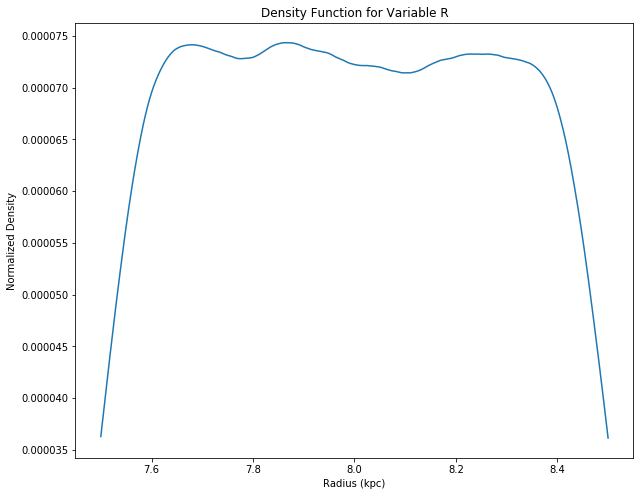

In [5]:
#Variable R plot
print('Variable R at Scotts bw')
plt.figure(figsize = (10, 8))
Rplot_epanechnikov = kde_qdf_epanechnikov(sample_R)
plt.plot(R_points, Rplot_epanechnikov)
plt.xlabel('Radius (kpc)')
plt.ylabel('Normalized Density')
plt.title('Density Function for Variable R')
plt.savefig('zscore_cyl_variable_R')
plt.show()

Variable phi at Scotts bw


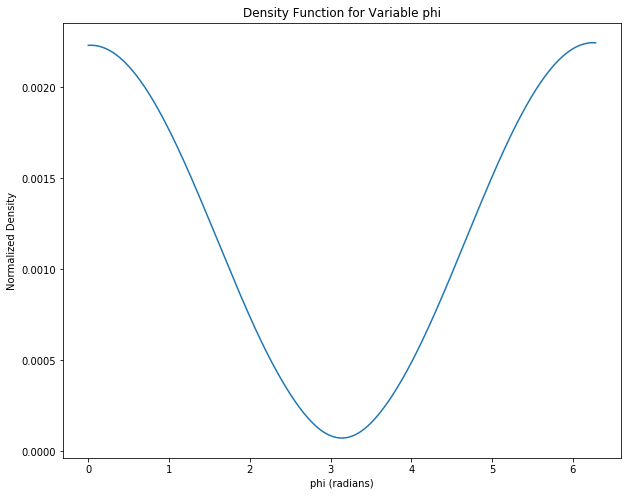

In [6]:
#Variable phi plot
print('Variable phi at Scotts bw')
plt.figure(figsize = (10, 8))
phiplot_epanechnikov = kde_qdf_epanechnikov(sample_phi)
plt.plot(phi_points, phiplot_epanechnikov)
plt.xlabel('phi (radians)')
plt.ylabel('Normalized Density')
plt.title('Density Function for Variable phi')
plt.savefig('zscore_cyl_variable_phi')
plt.show()

Variable z at Scotts bw


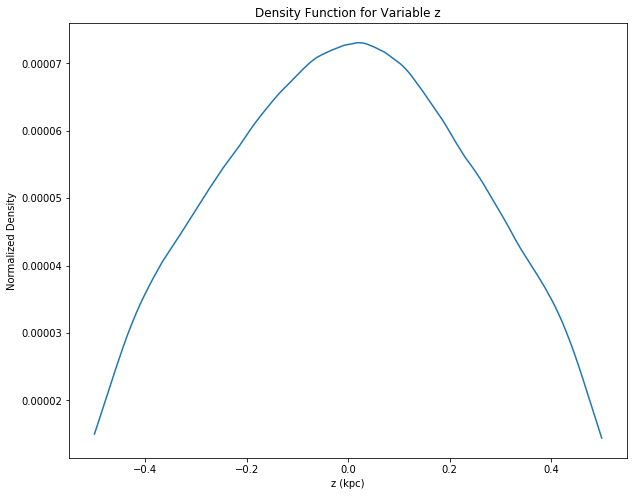

In [7]:
#Variable z plot
print('Variable z at Scotts bw')
plt.figure(figsize = (10, 8))
zplot_epanechnikov = kde_qdf_epanechnikov(sample_z)
plt.plot(z_points, zplot_epanechnikov)
plt.xlabel('z (kpc)')
plt.ylabel('Normalized Density')
plt.title('Density Function for Variable z')
plt.savefig('zscore_cyl_variable_z')
plt.show()

Variable vR at Scotts bw


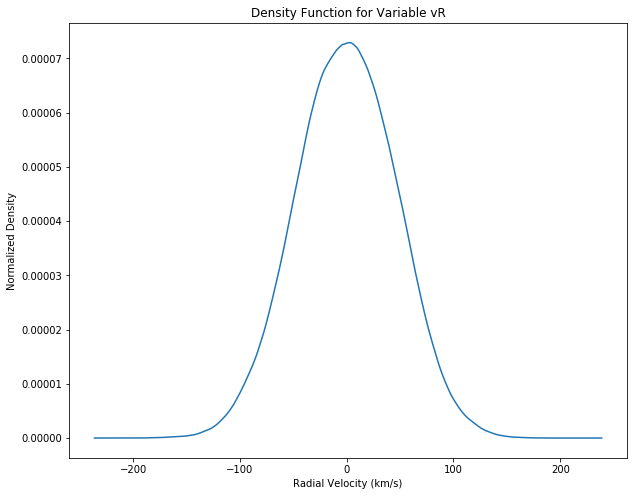

In [8]:
#Variable vR plot
print('Variable vR at Scotts bw')
plt.figure(figsize = (10, 8))
vRplot_epanechnikov = kde_qdf_epanechnikov(sample_vR)
plt.plot(vR_points, vRplot_epanechnikov)
plt.xlabel('Radial Velocity (km/s)')
plt.ylabel('Normalized Density')
plt.title('Density Function for Variable vR')
plt.savefig('zscore_cyl_variable_vR')
plt.show()

Variable vT at Scotts bw


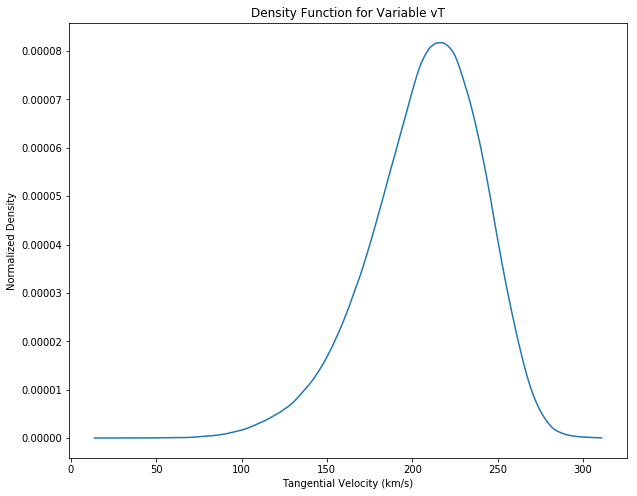

In [9]:
#Variable vT plot
print('Variable vT at Scotts bw')
plt.figure(figsize = (10, 8))
vTplot_epanechnikov = kde_qdf_epanechnikov(sample_vT)
plt.plot(vT_points, vTplot_epanechnikov)
plt.xlabel('Tangential Velocity (km/s)')
plt.ylabel('Normalized Density')
plt.title('Density Function for Variable vT')
plt.savefig('zscore_cyl_variable_vT')
plt.show()

Variable vz at Scotts bw


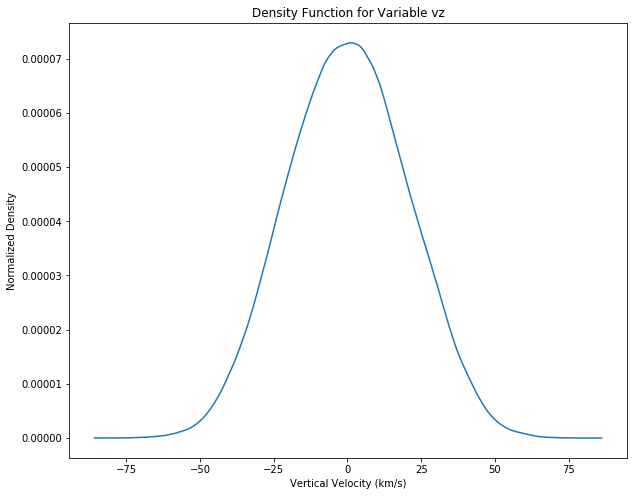

In [10]:
#Variable vz plot
print('Variable vz at Scotts bw')
plt.figure(figsize = (10, 8))
vzplot_epanechnikov = kde_qdf_epanechnikov(sample_vz)
plt.plot(vz_points, vzplot_epanechnikov)
plt.xlabel('Vertical Velocity (km/s)')
plt.ylabel('Normalized Density')
plt.title('Density Function for Variable vz')
plt.savefig('zscore_cyl_variable_vz')
plt.show()

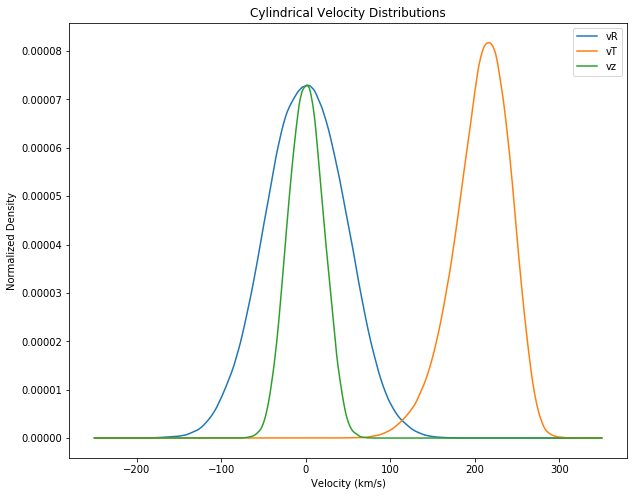

In [11]:
#For variable vR
vR_points = np.linspace(-250, 350, N)
vR_points = vR_points.reshape(-1, 1)
sample_vR = np.hstack((mean_R, mean_phi, mean_z, vR_points, mean_vT, mean_vz))

#For variable vT
vT_points = np.linspace(-250, 350, N)
vT_points = vT_points.reshape(-1, 1)
sample_vT = np.hstack((mean_R, mean_phi, mean_z, mean_vR, vT_points, mean_vz))
                 
#For variable vz
vz_points = np.linspace(-250, 350, N)
vz_points = vz_points.reshape(-1, 1)
sample_vz = np.hstack((mean_R, mean_phi, mean_z, mean_vR, mean_vT, vz_points))

#Overplotting velocities
plt.figure(figsize = (10, 8))

#Epanechnikov, vR, Scotts
vRplot_epanechnikov = kde_qdf_epanechnikov(sample_vR)
plt.plot(vR_points, vRplot_epanechnikov, label='vR')

#Epanechnikov, vT, Scotts
vTplot_epanechnikov = kde_qdf_epanechnikov(sample_vT)
plt.plot(vT_points, vTplot_epanechnikov, label='vT')

#Epanechnikov, vz, Scotts
vzplot_epanechnikov = kde_qdf_epanechnikov(sample_vz)
plt.plot(vz_points, vzplot_epanechnikov, label='vz')

#Show plot
plt.xlabel('Velocity (km/s)')
plt.ylabel('Normalized Density')
plt.title('Cylindrical Velocity Distributions')
plt.legend()
plt.savefig('zscore_cyl_velocity_distribution')
plt.show()

In [12]:
from scipy.integrate import tplquad
import time

#Input values for R
R_input = np.linspace(7, 9, 100)

# -----------------
# Integrate over R
# -----------------

def kde_qdf_cyl_R(vT, vz, vR, R, phi, z):
    evaluation = kde_qdf_epanechnikov(np.array([[R, phi, z, vR, vT, vz]]))
    return evaluation

def integrate_over_R(kde_qdf_epanechnikov, R): #bounds of vT = [0, 300], bounds of vz = [-100, 100], bounds of vR = [-200, 200]
    print ("Evaluating at R =", R)
    return tplquad(kde_qdf_cyl_R, 0., 300., -100., 100., -200., 200., args=([R, 3.14, 0.]), epsabs=0.1)  # args=(R, phi, z)

R_output = np.ones([100])


print("With phi, z = 3.14, 0., integrating over vT from [0, 300], vz from [-100, 100] and vR from [-200, 200]")
print("KDE Evaluations along R from [7, 9] kpc over 100 subintervals.")
print()

counter = 0
start_overall = time.time()

for r in np.nditer(R_input):
    counter += 1
    print("Evaluation:", counter)
    start = time.time()
    R_output[counter - 1], error = integrate_over_R(kde_qdf_epanechnikov, r)
    print("Value:", R_output[counter - 1])
    end = time.time()
    print("Time to integrate: "'{}'"s".format(round(end - start, 2)))
    print("Time elapsed: "'{}'" min".format(round((end - start_overall)/60, 2)))
    print()

#Input values for z
z_input = np.linspace(-1, 1, 100)

# -----------------
# Integrate over z
# -----------------

def kde_qdf_cyl_z(vT, vz, vR, R, phi, z):
    evaluation = kde_qdf_epanechnikov(np.array([[R, phi, z, vR, vT, vz]]))
    return evaluation

def integrate_over_z(kde_qdf_epanechnikov, z): #bounds of vT = [0, 300], bounds of vz = [-100, 100], bounds of vR = [-200, 200]
    print ("Evaluating at z =", z)
    return tplquad(kde_qdf_cyl_z, 0., 300., -100., 100., -200., 200., args=([8.3, 3.14, z]), epsabs=0.1)  # args=(R, phi, z)

z_output = np.ones([100])


print("With phi, R = 3.14, 8.3, integrating over vT from [0, 300], vz from [-100, 100] and vR from [-200, 200]")
print("KDE Evaluations along z from [-1, 1] kpc over 100 subintervals.")
print()

counter = 0
start_overall = time.time()

for zstep in np.nditer(z_input):
    counter += 1
    print("Evaluation:", counter)
    start = time.time()
    z_output[counter - 1], error = integrate_over_z(kde_qdf_epanechnikov, zstep)
    print("Value:", z_output[counter - 1])
    end = time.time()
    print("Time to integrate: "'{}'"s".format(round(end - start, 2)))
    print("Time elapsed: "'{}'" min".format(round((end - start_overall)/60, 2)))
    print()

With phi, z = 3.14, 0., integrating over vT from [0, 300], vz from [-100, 100] and vR from [-200, 200]
KDE Evaluations along R from [7, 9] kpc over 100 subintervals.

Evaluation: 1
Evaluating at R = 7.0
Value: 0.0
Time to integrate: 2.88s
Time elapsed: 0.05 min

Evaluation: 2
Evaluating at R = 7.02020202020202
Value: 0.0
Time to integrate: 2.83s
Time elapsed: 0.1 min

Evaluation: 3
Evaluating at R = 7.040404040404041
Value: 0.0
Time to integrate: 2.84s
Time elapsed: 0.14 min

Evaluation: 4
Evaluating at R = 7.0606060606060606
Value: 0.0
Time to integrate: 3.05s
Time elapsed: 0.19 min

Evaluation: 5
Evaluating at R = 7.08080808080808
Value: 0.0
Time to integrate: 3.21s
Time elapsed: 0.25 min

Evaluation: 6
Evaluating at R = 7.101010101010101
Value: 0.0
Time to integrate: 3.61s
Time elapsed: 0.31 min

Evaluation: 7
Evaluating at R = 7.121212121212121
Value: 0.0
Time to integrate: 3.43s
Time elapsed: 0.36 min

Evaluation: 8
Evaluating at R = 7.141414141414142
Value: 0.0
Time to integrate:

Value: 8.303262320352939
Time to integrate: 119.09s
Time elapsed: 118.64 min

Evaluation: 66
Evaluating at R = 8.313131313131313
Value: 8.230541864502728
Time to integrate: 144.87s
Time elapsed: 121.06 min

Evaluation: 67
Evaluating at R = 8.333333333333334
Value: 8.157367507797895
Time to integrate: 143.33s
Time elapsed: 123.45 min

Evaluation: 68
Evaluating at R = 8.353535353535353
Value: 8.063203584114202
Time to integrate: 135.85s
Time elapsed: 125.71 min

Evaluation: 69
Evaluating at R = 8.373737373737374
Value: 7.903753679051248
Time to integrate: 137.5s
Time elapsed: 128.0 min

Evaluation: 70
Evaluating at R = 8.393939393939394
Value: 7.638887116285029
Time to integrate: 137.44s
Time elapsed: 130.29 min

Evaluation: 71
Evaluating at R = 8.414141414141415
Value: 7.228450426697287
Time to integrate: 85.22s
Time elapsed: 131.72 min

Evaluation: 72
Evaluating at R = 8.434343434343434
Value: 6.6521800524516825
Time to integrate: 96.58s
Time elapsed: 133.32 min

Evaluation: 73
Evaluat

Value: 3.7188726148522253
Time to integrate: 30.21s
Time elapsed: 24.8 min

Evaluation: 31
Evaluating at z = -0.3939393939393939
Value: 4.067665040235509
Time to integrate: 30.02s
Time elapsed: 25.3 min

Evaluation: 32
Evaluating at z = -0.3737373737373737
Value: 4.369488557507631
Time to integrate: 150.02s
Time elapsed: 27.8 min

Evaluation: 33
Evaluating at z = -0.3535353535353535
Value: 4.645000640526872
Time to integrate: 73.21s
Time elapsed: 29.02 min

Evaluation: 34
Evaluating at z = -0.33333333333333326
Value: 4.923711724900133
Time to integrate: 116.49s
Time elapsed: 30.96 min

Evaluation: 35
Evaluating at z = -0.31313131313131304
Value: 5.2011849118944316
Time to integrate: 175.18s
Time elapsed: 33.88 min

Evaluation: 36
Evaluating at z = -0.2929292929292928
Value: 5.4769778158928055
Time to integrate: 185.52s
Time elapsed: 36.97 min

Evaluation: 37
Evaluating at z = -0.2727272727272727
Value: 5.749973612721283
Time to integrate: 98.44s
Time elapsed: 38.61 min

Evaluation: 38


Value: 0.0
Time to integrate: 3.78s
Time elapsed: 134.43 min

Evaluation: 95
Evaluating at z = 0.8989898989898992
Value: 0.0
Time to integrate: 3.79s
Time elapsed: 134.49 min

Evaluation: 96
Evaluating at z = 0.9191919191919193
Value: 0.0
Time to integrate: 3.82s
Time elapsed: 134.56 min

Evaluation: 97
Evaluating at z = 0.9393939393939394
Value: 0.0
Time to integrate: 3.84s
Time elapsed: 134.62 min

Evaluation: 98
Evaluating at z = 0.9595959595959598
Value: 0.0
Time to integrate: 3.83s
Time elapsed: 134.68 min

Evaluation: 99
Evaluating at z = 0.9797979797979799
Value: 0.0
Time to integrate: 3.87s
Time elapsed: 134.75 min

Evaluation: 100
Evaluating at z = 1.0
Value: 0.0
Time to integrate: 3.95s
Time elapsed: 134.81 min



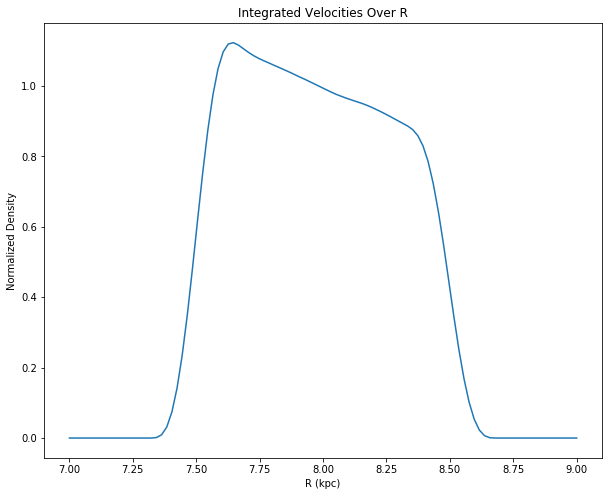

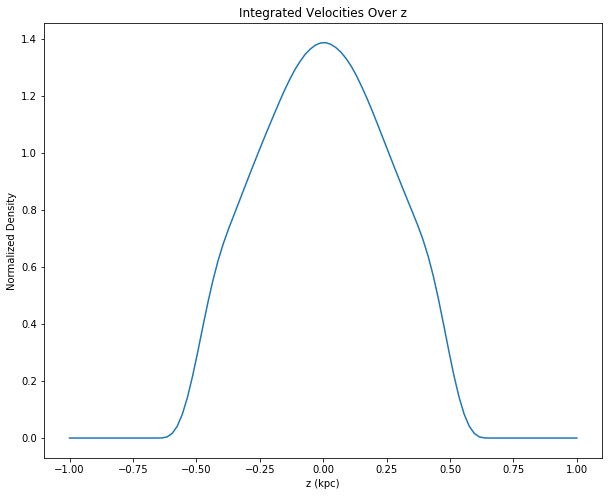

In [14]:
#Plotting densities with varrying R and z and integrated velocities
plt.figure(figsize=(10,8))
plt.plot(R_input, R_output/np.sum(R_output)/(R_input[1] - R_input[0]))
plt.title('Integrated Velocities Over R')
plt.xlabel('R (kpc)')
plt.ylabel('Normalized Density')
plt.savefig('new_zscore_cyl_integrated_R')
plt.show()

plt.figure(figsize=(10,8))
plt.plot(z_input, z_output/np.sum(z_output)/(z_input[1] - z_input[0]))
plt.title('Integrated Velocities Over z')
plt.xlabel('z (kpc)')
plt.ylabel('Normalized Density')
plt.savefig('new_zscore_cyl_integrated_z')
plt.show()